# Online analytical processing (OLAP) based on Victim's Sex, Locality, Ethnicity

### code written by: Harshitha Sarva (Student ID: 862323552)
                    

In [1]:
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
import warnings
import os
import time
from csv import reader
from pyspark.sql import Row 
from pyspark.sql import SparkSession
from pyspark.sql.types import FloatType, BooleanType
from pyspark.sql.functions import to_timestamp, concat, lit, udf, upper, to_timestamp, to_date
import seaborn as sns

### Importing data and creating spark session

In [2]:
from pyspark.sql import SparkSession
spark = SparkSession \
    .builder \
    .appName("crime analysis") \
    .config("spark.some.config.option", "some-value") \
    .getOrCreate()

### Loading the dataset

In [3]:
df = spark.read.format("csv").option("header", "true").load("Crime_Data.csv")


In [4]:
#To display the data
df.show()

+---------+--------------------+--------------------+--------+-----+---------+-----------+--------+------+--------------------+--------------+--------+--------+------------+---------+--------------------+--------------+--------------------+------+------------+--------+--------+--------+--------+--------------------+--------------------+-------+---------+
|    DR_NO|           Date Rptd|            DATE OCC|TIME OCC|AREA |AREA NAME|Rpt Dist No|Part 1-2|Crm Cd|         Crm Cd Desc|       Mocodes|Vict Age|Vict Sex|Vict Descent|Premis Cd|         Premis Desc|Weapon Used Cd|         Weapon Desc|Status| Status Desc|Crm Cd 1|Crm Cd 2|Crm Cd 3|Crm Cd 4|            LOCATION|        Cross Street|    LAT|      LON|
+---------+--------------------+--------------------+--------+-----+---------+-----------+--------+------+--------------------+--------------+--------+--------+------------+---------+--------------------+--------------+--------------------+------+------------+--------+--------+--------

### Preprocessing

In [5]:
#Selecting necessary columns
dfn = df.select("AREA NAME",  "Vict Sex")


In [6]:
#Shows the data
dfn.show()

+---------+--------+
|AREA NAME|Vict Sex|
+---------+--------+
|   Newton|       M|
|  Pacific|       M|
|   Newton|       M|
|Hollywood|       F|
|  Central|       F|
|  Central|       M|
|  Central|       M|
|  Central|       M|
|  Central|       M|
|  Central|       M|
|  Central|       F|
|  Central|       M|
|  Central|       F|
|  Central|       F|
|  Central|       M|
|  Central|       M|
|  Central|       M|
|  Central|       M|
|  Central|       F|
|  Central|       M|
+---------+--------+
only showing top 20 rows



In [7]:
#check the null values
null_count = dfn.where(dfn['AREA NAME'].isNull()).count()
print('Null Values: ',null_count)
null_count = dfn.where(dfn['Vict Sex'].isNull()).count()
print('Null Values: ',null_count)

Null Values:  0
Null Values:  196766


In [83]:
dfn.show()

+---------+--------+
|AREA NAME|Vict Sex|
+---------+--------+
|   Newton|       M|
|  Pacific|       M|
|   Newton|       M|
|Hollywood|       F|
|  Central|       F|
|  Central|       M|
|  Central|       M|
|  Central|       M|
|  Central|       M|
|  Central|       M|
|  Central|       F|
|  Central|       M|
|  Central|       F|
|  Central|       F|
|  Central|       M|
|  Central|       M|
|  Central|       M|
|  Central|       M|
|  Central|       F|
|  Central|       M|
+---------+--------+
only showing top 20 rows



In [8]:
#Check the unique values
dfn.select('Vict Sex').distinct().collect()

[Row(Vict Sex='F'),
 Row(Vict Sex=None),
 Row(Vict Sex='M'),
 Row(Vict Sex='-'),
 Row(Vict Sex='X'),
 Row(Vict Sex='H'),
 Row(Vict Sex='N')]

In [9]:
#drop the values which are not categorized as male/female
dfn = dfn.where(dfn['Vict Sex']!='N')
dfn = dfn.where(dfn['Vict Sex']!='X')
dfn = dfn.where(dfn['Vict Sex']!='H')
dfn = dfn.where(dfn['Vict Sex']!='-')

In [10]:
#coverting to pandas dataframe for visualization
dfn = dfn.toPandas()

### Visualization:

#### Number of Victims based on Gender in each locality

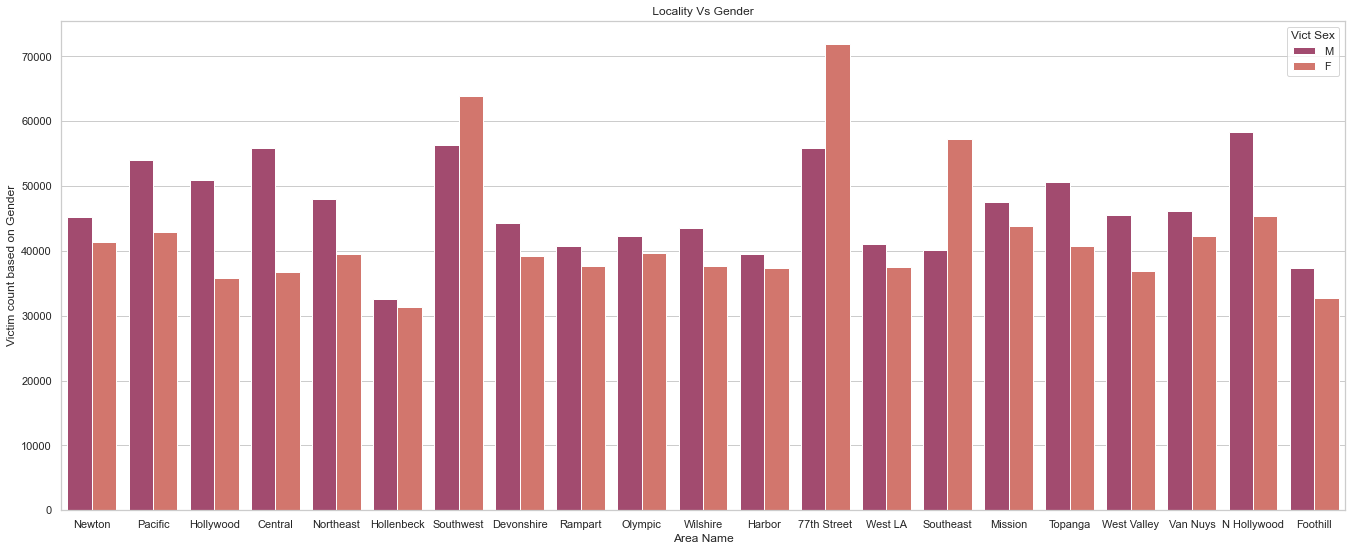

In [11]:
sns.set(rc={'figure.figsize':(23,9)})
sns.set_theme(style="whitegrid")
ax = sns.countplot(data=dfn,x='AREA NAME',hue='Vict Sex',palette= ['#b13c6c',"#e3685c"])
ax.set(xlabel='Area Name', ylabel='Victim count based on Gender', title=" Locality Vs Gender ")
plt.show()

This graph depicts the number of individuals who were harmed in each area based on their gender. We can see that men have been the victims in the majority of communities


In [12]:
#Selecting necessary columns
df1 = df.select("AREA NAME",  "Vict Sex", "Vict Descent")

In [13]:
null_count = df1.where(df1['AREA NAME'].isNull()).count()
print('Null Values: ',null_count)
null_count = df1.where(df1['Vict Sex'].isNull()).count()
print('Null Values: ',null_count)

Null Values:  0
Null Values:  196766


In [14]:
df1 = df1.dropna()

In [15]:
null_count = df1.where(df1['AREA NAME'].isNull()).count()
print('Null Values: ',null_count)
null_count = df1.where(df1['Vict Sex'].isNull()).count()
print('Null Values: ',null_count)

Null Values:  0
Null Values:  0


In [16]:
df1 = df1.toPandas()

### Total Number of Victims based on their Descent 

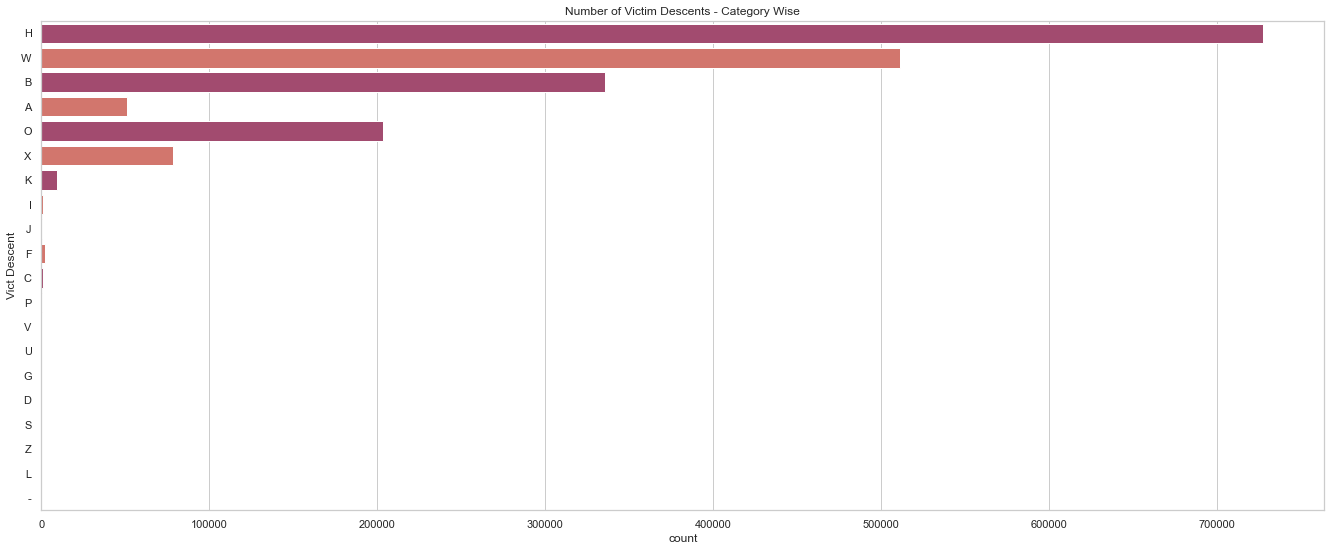

In [18]:
#Vict Descent in the area
sns.set_theme(style="whitegrid")
#labels = ['Hispanic/Latin/Mexican', 'White', 'Black', 'Asian']
sns.countplot(y=df1["Vict Descent"],palette=['#b13c6c',"#e3685c"])
plt.title("Number of Victim Descents - Category Wise")
plt.show()

The above graph shows the total number of victims based on their ethnicities:
Below are the ethnicities found in the dataset
Descent Code: A - Other Asian 
              B - Black
              C - Chinese
              D - Cambodian
              F - Filipino 
              G - Guamanian 
              H - Hispanic/Latin/Mexican 
              I - American Indian/Alaskan Native 
              J - Japanese K - Korean 
              L - Laotian 
              O - Other 
              P - Pacific Islander 
              S - Samoan 
              U - Hawaiian 
              V - Vietnamese 
              W - White 
              Z - Asian Indian


In [19]:
#dropping ethnicities with least number of crimes
df1 = df1.drop(df1[df1['Vict Descent'] == 'K'].index)
df1 = df1.drop(df1[df1['Vict Descent'] == 'I'].index)
df1 = df1.drop(df1[df1['Vict Descent'] == 'J'].index)
df1 = df1.drop(df1[df1['Vict Descent'] == 'F'].index)
df1 = df1.drop(df1[df1['Vict Descent'] == 'C'].index)
df1 = df1.drop(df1[df1['Vict Descent'] == 'P'].index)
df1 = df1.drop(df1[df1['Vict Descent'] == 'V'].index)
df1 = df1.drop(df1[df1['Vict Descent'] == 'U'].index)
df1 = df1.drop(df1[df1['Vict Descent'] == 'G'].index)

df1 = df1.drop(df1[df1['Vict Descent'] == 'D'].index)
df1 = df1.drop(df1[df1['Vict Descent'] == 'S'].index)
df1 = df1.drop(df1[df1['Vict Descent'] == 'Z'].index)
df1 = df1.drop(df1[df1['Vict Descent'] == 'L'].index)
df1 = df1.drop(df1[df1['Vict Descent'] == '-'].index)
df1 = df1.drop(df1[df1['Vict Descent'] == 'X'].index)
df1 = df1.drop(df1[df1['Vict Descent'] == 'O'].index)


In [20]:
#finding the unique value in the areas column
print("unique values in victim Descent after replacing", df1['Vict Descent'].unique())
print("unique values in Area Names after replacing", df1['AREA NAME'].unique())
area_list = df1['AREA NAME'].unique()
print(area_list)

unique values in victim Descent after replacing ['H' 'W' 'B' 'A']
unique values in Area Names after replacing ['Newton' 'Pacific' 'Hollywood' 'Central' 'Northeast' 'Hollenbeck'
 'Devonshire' 'Rampart' 'Southwest' 'Olympic' 'Harbor' '77th Street'
 'Wilshire' 'West LA' 'Southeast' 'Topanga' 'Mission' 'West Valley'
 'Van Nuys' 'N Hollywood' 'Foothill']
['Newton' 'Pacific' 'Hollywood' 'Central' 'Northeast' 'Hollenbeck'
 'Devonshire' 'Rampart' 'Southwest' 'Olympic' 'Harbor' '77th Street'
 'Wilshire' 'West LA' 'Southeast' 'Topanga' 'Mission' 'West Valley'
 'Van Nuys' 'N Hollywood' 'Foothill']


### Shows top 4 ethnicities based on number of crimes

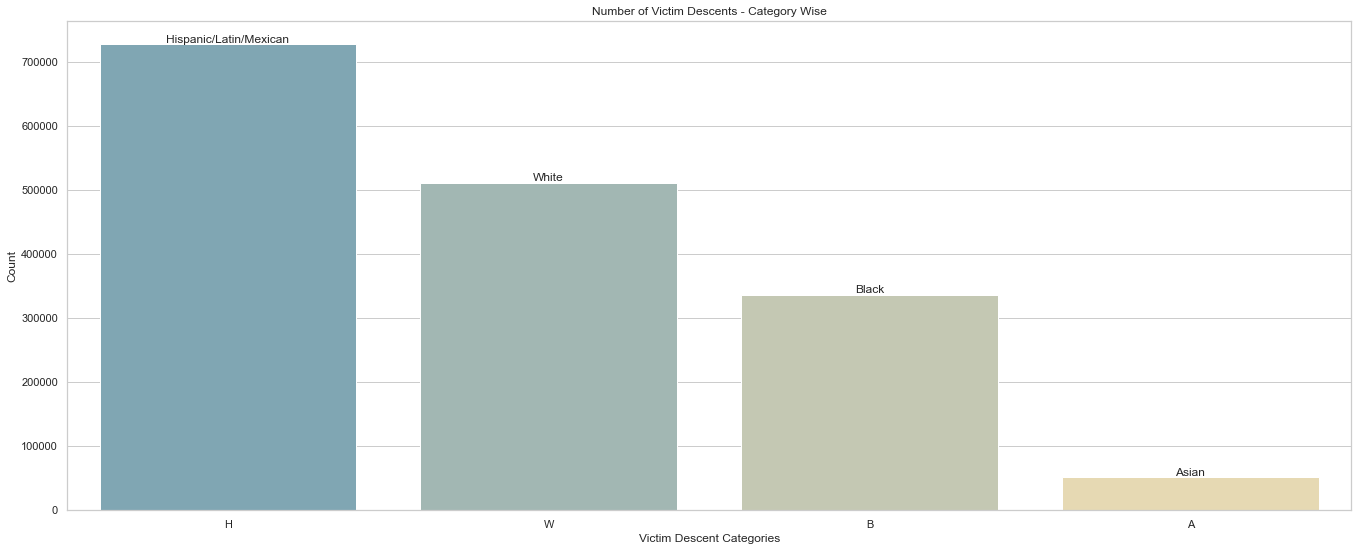

In [21]:
sns.set_theme(style="whitegrid")
labels = ['Hispanic/Latin/Mexican', 'White', 'Black', 'Asian']

ax = sns.countplot(x=df1["Vict Descent"],palette="blend:#7AB,#EDA")
plt.title("Number of Victim Descents - Category Wise")
ax.bar_label(container=ax.containers[0],labels=labels)
plt.ylabel('Count')
plt.xlabel('Victim Descent Categories')

plt.show()


This graph shows the number of victims categorized based on their descent. We observe Hispanic, White and Black are the top categories where the Victims are present.


In [22]:
import copy
areas = copy.deepcopy(area_list)

### Pie chart to visualize the number of victims in top 4 ethnicities distributed in each area

['Newton' 'Pacific' 'Hollywood']


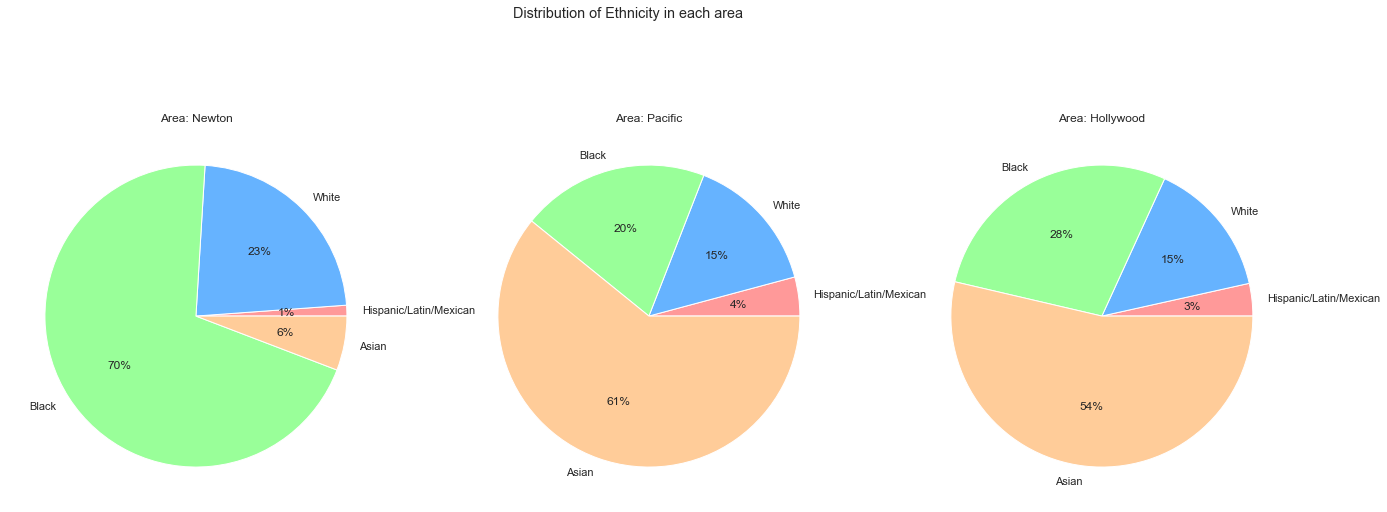

In [24]:
	
labels = ['Hispanic/Latin/Mexican', 'White', 'Black', 'Asian']
fig, ax = plt.subplots(1,3)
colors = ['#ff9999','#66b3ff','#99ff99','#ffcc99']
areas = copy.deepcopy(area_list)
areas = areas[:3]
print(areas)
for i in range(0,3):
    ax[i].pie(df1[df1["AREA NAME"] == areas[i]].groupby(["Vict Descent"]).size(),labels=labels, colors=colors, autopct='%1.0f%%')
    ax[i].set_title("Area: "+areas[i])
fig.suptitle("Distribution of Ethnicity in each area")
plt.show()

This graph shows the number of victims in each area based on their descent. The area list here has the list of areas and this plot loops through the areas and plots pie chart individually. It is useful in determining which groups of people are being targeted in a specific area.

This pie chart shows the distribution of victims over top 5 ethnicities in the areas of Newton, Pacific, Hollywood

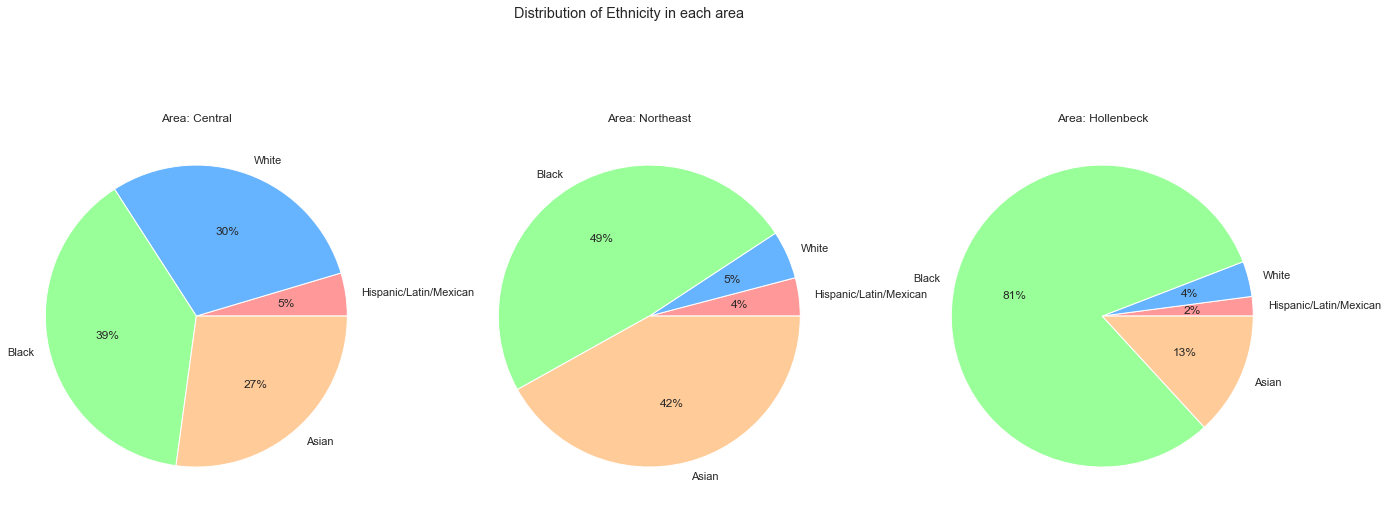

In [26]:
fig, ax = plt.subplots(1,3)
areas = copy.deepcopy(area_list)
areas = areas[3:6]
for i in range(0,3):
    ax[i].pie(df1[df1["AREA NAME"] == areas[i]].groupby(["Vict Descent"]).size(),labels=labels, colors=colors, autopct='%1.0f%%')
    ax[i].set_title("Area: "+areas[i])
    
fig.suptitle("Distribution of Ethnicity in each area")
plt.show()

This pie chart shows the distribution of victims over top 5 ethnicities in the areas of Central, Northeast, Hollenbeck

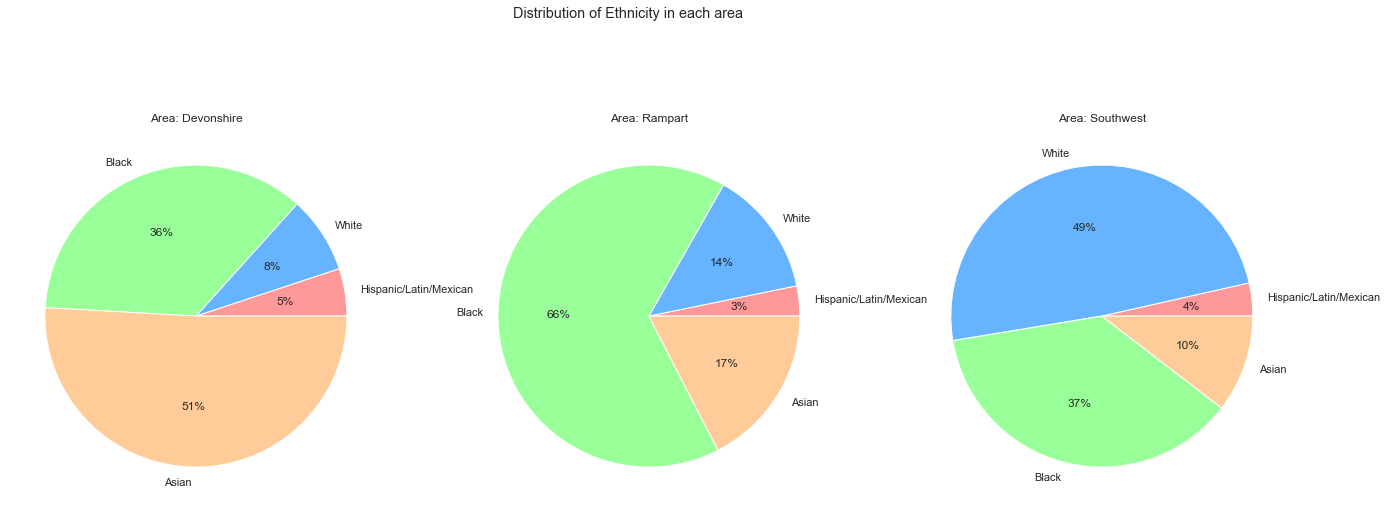

In [27]:
fig, ax = plt.subplots(1,3)
areas = copy.deepcopy(area_list)   
areas = areas[6:]

for i in range(0,3):
    ax[i].pie(df1[df1["AREA NAME"] == areas[i]].groupby(["Vict Descent"]).size(),labels=labels, colors=colors, autopct='%1.0f%%')
    ax[i].set_title("Area: "+areas[i])
fig.suptitle("Distribution of Ethnicity in each area")
plt.show()


This pie chart shows the distribution of victims over top 5 ethnicities in the areas of Devonshire, Rampart, Southwest

### Number of Victims Vs all the ethnicities  in each area

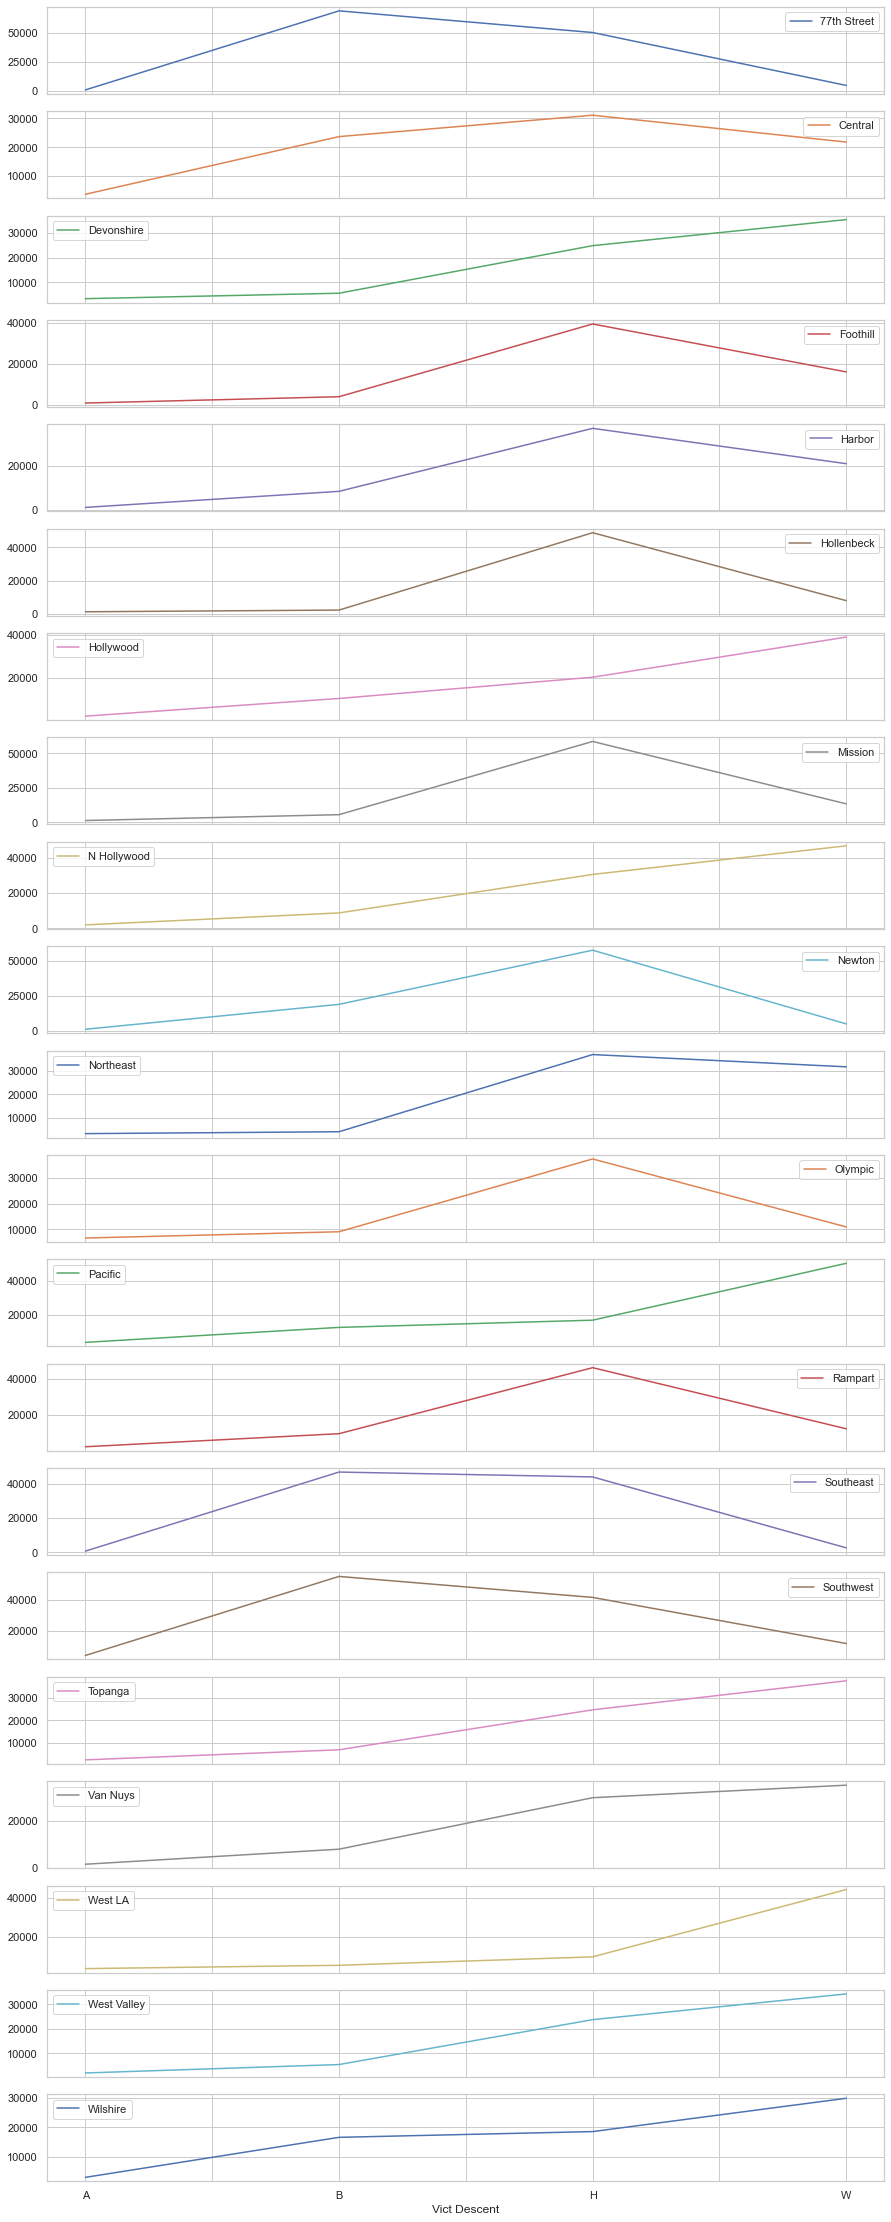

In [28]:
df_new = df1[['AREA NAME', 'Vict Descent']]
df_new.head()
df_new = (df_new.groupby(['AREA NAME', 'Vict Descent'])['Vict Descent']
         .agg([('Count','size'), ('Col4_sum','sum')])
         .reset_index())

pd.pivot_table(df_new.reset_index(),index='Vict Descent',columns='AREA NAME', values='Count').plot(subplots=True, figsize = (15,40))
plt.show()

This graph shows the number of victims in each area based on their descent. It is useful in determining which groups of people are being targeted in a specific area. This graph has an overall view of number of victims based distributed over all the possible ethnicities